In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
#from specutils.fitting import find_lines_threshold, find_lines_derivative
#from scipy.optimize import curve_fit
#from astropy.stats import sigma_clip
from glob import glob
from scipy.signal import find_peaks
from specutils.manipulation import LinearInterpolatedResampler

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [2]:
spectrum_files = glob(os.path.join('HST','anonymous37222', '*.fits'))

In [193]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [194]:
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [ ]:
INST_head = [fits.getheader(file, ext=0) for file in spectrum_files]
SCI_head = [fits.getheader(file, ext=1) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [50]:
#date = [header['DATE-OBS'] for header in spectrum_header]
#observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header_0]
#instrument_filter = [header['OPT_ELEM'] for header in spectrum_header_0]

In [ ]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
#lab_emission_lines = lines['lab_lambda']
#transition_grouped_lines = lines.groupby("[nu', J']")

In [ ]:
spectrum_x1d[0]

In [ ]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
#wavesort_idx = np.argsort(x1d_wavelength)
#x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

#x1d_flux = x1d_flux[wavesort_idx]
#x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [ ]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [ ]:
peaks , _ = find_peaks(np.array(x1d_flux), height=max(x1d_fluxerr.value)*2, distance=100)

In [ ]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [ ]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

In [ ]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [ ]:
line_width = 150
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]

In [ ]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [ ]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = x1d_h2_emissions_flux
fluxerr = x1d_h2_emissions_fluxerr
wavelength = x1d_h2_emissions_wavelength

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)

In [ ]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

In [ ]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function

In [2]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=False)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
#plt.rcParams['figure.dpi'] = 300

In [3]:
#Keep units for future math
class spectrum():
    def __init__(self, files, linelist_file):
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = None
        self.linelist = pd.read_csv(linelist_file, skiprows=2)
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)
            
            self.x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            self.x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            self.x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            if "cspec" in file:
                date = SCI_head['DATE-BEG'][:10]
            elif "x1dsum" in file:
                date = SCI_head['DATE-OBS']
            instrument = INST_head['INSTRUME']
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header
            df_data = {'filename':file, 
                       'obsdate':date,
                       'instrument':instrument, 
                       'filter':instrument_filter, 
                       'wavelength':self.x1d_wavelength*self.wavelength_units, 
                       'flux': self.x1d_flux*self.flux_units, 
                       'fluxerr':self.x1d_fluxerr*self.flux_units}
            rows.append(pd.Series(df_data))
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)
        self.spec_df['obsdate'] = self.spec_df['obsdate'].astype(str)

    def coaddwave(self, df, columns=['obsdate'], velocity=False):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - df: The dataframe to use for co-adding. Must contain 'wavelength', 
              'flux', and 'fluxerr' columns at least. If using velocity_space, must contain 'rest_wavelength' column.
        - columns: the columns of unique combinations to apply coadding to.

        Returns:
        - coadded_spectrum: spectrum dataframe
        """

        res = {}
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]

            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]

            resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
            wavelengths = group['wavelength'].values
            fluxes = group['flux'].values
            fluxerrs = group['fluxerr'].values
            if velocity:
                lablines = group['labline'].values*self.wavelength_units
            else:
                lablines = [None] * len(wavelengths)
            
            template_axis = wavelengths[0][np.argsort(wavelengths[0])]
            template_flux = fluxes[0][np.argsort(wavelengths[0])]
            template_fluxerr = fluxerrs[0][np.argsort(wavelengths[0])]
            
            coadded = Spectrum1D(
                flux=template_flux,
                spectral_axis=template_axis,
                uncertainty=StdDevUncertainty(template_fluxerr)
            )
            if velocity:
                coadded.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=lablines[0])

            for i in np.arange(0, len(wavelengths)):
                x = wavelengths[i]
                flux = fluxes[i]
                err = fluxerrs[i]
                sort_idx = np.argsort(x)
                spec = Spectrum1D(spectral_axis=x[sort_idx], 
                                    flux=flux[sort_idx], 
                                    uncertainty=StdDevUncertainty(err[sort_idx])
                                )
                if velocity:
                    spec.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=lablines[i])
                
                spec_resampled = resampler(spec, coadded.spectral_axis)
                coadded += spec_resampled
            
            coadd_wave = coadded.wavelength
            coadd_flux = coadded.flux
            coadd_err = coadded.uncertainty.quantity.to(self.flux_units)
            if velocity:
                coadd_vel = coadded.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=lablines[0])
                spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err, 'velocity': coadd_vel}
            else:
                spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err}
            res[tuple(unique_values)] = spec_dict

        stacked_df = pd.DataFrame([
            {**dict(zip(columns, k)), **(v if v is not None else {})}
            for k, v in res.items()
        ])
        return stacked_df
    
    def H2lines_fromspectrum(self, df):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = None
        df["[nu', J']"] = None
        df["rest_wavelength"] = None
        for i in range(len(df)):
            row = df.iloc[i]
            #peaks , _ = find_peaks(np.array(row['flux'].value), height=np.array(row['fluxerr'].value)*2, distance=50)
            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = [] #wavelength array index
            nu_J = [] #transition of line from linelist
            lab_lines = [] #lab wavelength of emission line from linelist
            # if len(peaks)>=1:
            #     for il, l in enumerate(self.linelist['lab_lambda']):
            #         diff = abs(row['wavelength'][peaks]/u.AA-l)
            #         if min(diff) <= 2:
            #             emission_table_idx.append(peaks[np.argmin(diff)])
            #             nu_J.append(self.linelist['[nu\', J\']'].iloc[il])
            #             lab_lines.append(l)
            # else:
            #     pass
            
            for il, l in enumerate(self.linelist['lab_lambda'].values):
                wavelength = row['wavelength']/u.AA
                diffs = np.abs(wavelength-l)
                mask = diffs <= 0.2
                if np.any(mask):
                    min_idx = np.argmin(diffs)
                    emission_table_idx.append(min_idx)
                    nu_J.append(self.linelist.loc[il, '[nu\', J\']'])
                    lab_lines.append(l)
            df.at[i, 'H2line_idx'] = np.array(emission_table_idx)
            df.at[i, "[nu', J']"] = nu_J
            df.at[i, 'rest_wavelength'] = lab_lines
        return df

    def radial_velocity(self, wavelengths, labline):
        velocity = (wavelengths - labline*u.AA)/(labline*u.AA) * const.c.to(u.km/u.s)
        return velocity
    
    def get_lines(self, df):
        line_width = 150 #150 points on either side of the central line
        transitions = set(self.linelist['[nu\', J\']'])
        line_dict = {'transition': [],
                    'labline': [],
                    'obsdate': [],
                    'wavelength': [],
                    'flux': [],
                    'fluxerr': []}
        for target_nuJ in transitions:
            for _, row in df.iterrows():
                if target_nuJ in row["[nu', J']"]:
                    nuJ_array = np.atleast_1d(row["[nu', J']"])
                    h2_idx_array = np.atleast_1d(row['H2line_idx'])
                    targ_idx = np.flatnonzero(nuJ_array == target_nuJ)
                    line_idx = h2_idx_array[targ_idx]


                    for i, l in enumerate(line_idx):
                        waves = row['wavelength'][l-line_width:l+line_width]
                        line_dict['wavelength'].append(waves)
                        line_dict['flux'].append(row['flux'][l-line_width:l+line_width])
                        line_dict['fluxerr'].append(row['fluxerr'][l-line_width:l+line_width])
                        line_dict['obsdate'].append(row['obsdate'])
                        line_dict['transition'].append(target_nuJ)
                        line_dict['labline'].append(np.array(row['rest_wavelength'])[targ_idx[i]])
                else:
                    pass

        line_df = pd.DataFrame(line_dict)
        return line_df

# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [4]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
# cspec_files = ['HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e3_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e3_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e3_cspec.fits']
# spectrum_files = np.hstack([x1dsum_files, cspec_files])
all_spectra = spectrum(x1dsum_files, linelist_file='HST/emission_lines.csv')

In [5]:
stacked_df = all_spectra.coaddwave(all_spectra.spec_df, columns = ['obsdate', 'filter'])

In [6]:
all_spectra.H2lines_fromspectrum(stacked_df)

,obsdate,filter,wavelength,flux,fluxerr,H2line_idx,"[nu', J']",rest_wavelength
0,2011-07-20,G130M,"[1124.7185766387568 Angstrom, 1124.72853832954...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[30169, 30460, 31742, 32148, 28525, 28896, 320...","[[4,13], [3,16], [1,4], [3,0], [0,1], [0,2], [...","[1415.33, 1418.23, 1431.01, 1435.05, 1398.95, ..."
1,2011-07-20,G160M,"[1386.0412954067515 Angstrom, 1386.05353027634...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19172, 19752, 2394, 10087, 19634, 2631, 10458...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
2,2012-02-28,G130M,"[1124.9096635174221 Angstrom, 1124.91962690073...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[30144, 30435, 31718, 32123, 28501, 28872, 320...","[[4,13], [3,16], [1,4], [3,0], [0,1], [0,2], [...","[1415.33, 1418.23, 1431.01, 1435.05, 1398.95, ..."
3,2012-02-28,G160M,"[1386.2769487823698 Angstrom, 1386.28918573199...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19150, 19730, 2374, 10066, 19612, 2611, 10437...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
4,2021-08-10,G230L,"[1629.7767989689344 Angstrom, 1630.16885217535...",[-8.040355697789332e-16 erg / (Angstrom s cm2)...,"[3.668935098550417e-14 erg / (Angstrom s cm2),...",17,"[[3,0]]",[1636.34]
5,2021-08-10,G160M,"[1385.9946471407397 Angstrom, 1386.00688689571...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10086, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
6,2021-08-11,G160M,"[1385.9941396590698 Angstrom, 1386.00637941009...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10086, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
7,2021-08-12,G230L,"[1302.44952981175 Angstrom, 1302.864435088827 ...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[753, 771, 274, 506, 767, 281, 517, 715, 785, ...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
8,2021-08-12,G160M,"[1385.9934968299058 Angstrom, 1386.00573657483...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10087, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
9,2021-08-13,G230L,"[1630.0907947696835 Angstrom, 1630.48284648384...","[1.834981277742598e-14 erg / (Angstrom s cm2),...","[4.008633769678648e-14 erg / (Angstrom s cm2),...",16,"[[3,0]]",[1636.34]


# Some code to investigate fluxerr and flux in the spectrum and how it affects peak finding

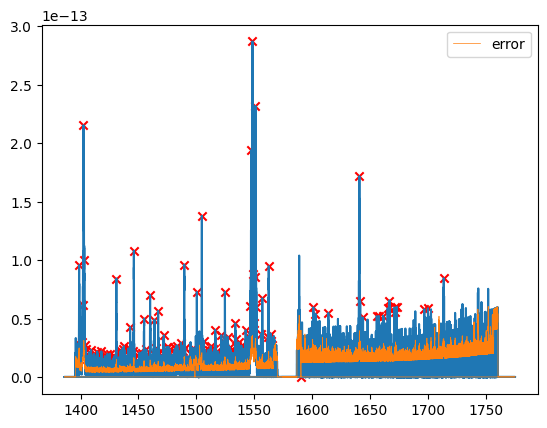

In [171]:
date_filter = all_spectra.spec_df['obsdate']=='2022-08-14'

flux = all_spectra.spec_df.loc[date_filter, 'flux'].values[0].value
fluxerr = all_spectra.spec_df.loc[date_filter, 'fluxerr'].values[0].value
wavelength = all_spectra.spec_df.loc[date_filter, 'wavelength'].values[0].value

peaks, _ = find_peaks(flux, height=fluxerr*2, distance=50)
#print(peaks)
plt.plot(wavelength, flux)
plt.scatter(wavelength[peaks], flux[peaks], c='red', marker='x')
#plt.hlines(np.mean(fluxerr[flux>0]), min(wavelength), max(wavelength), 'r','--')
plt.plot(wavelength, fluxerr, lw=0.5, label='error')
plt.legend()
#plt.xlim(left=1390)
plt.show()

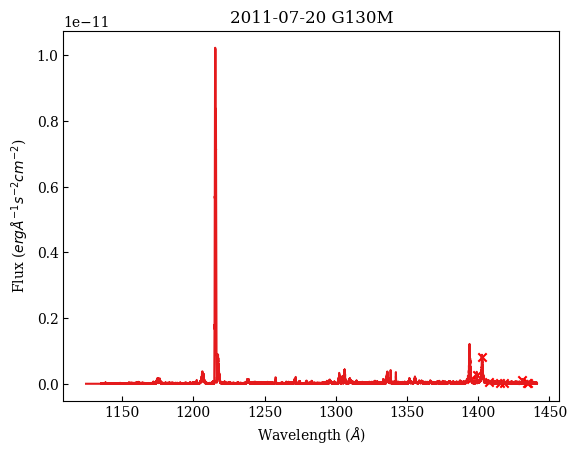

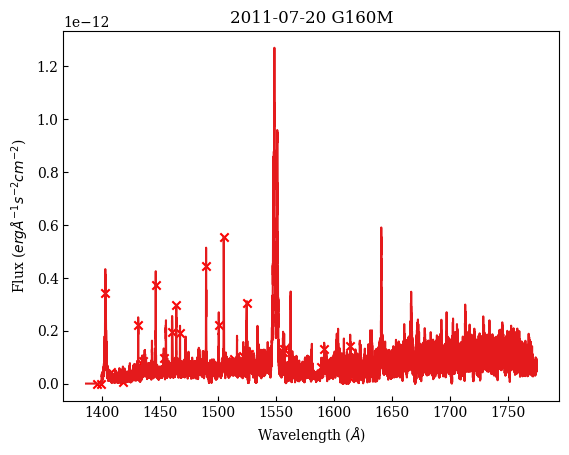

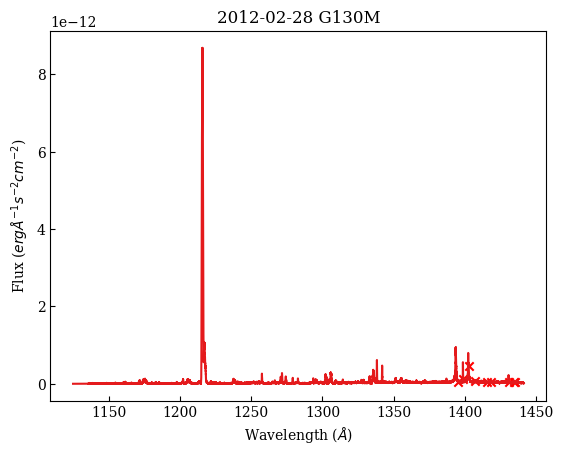

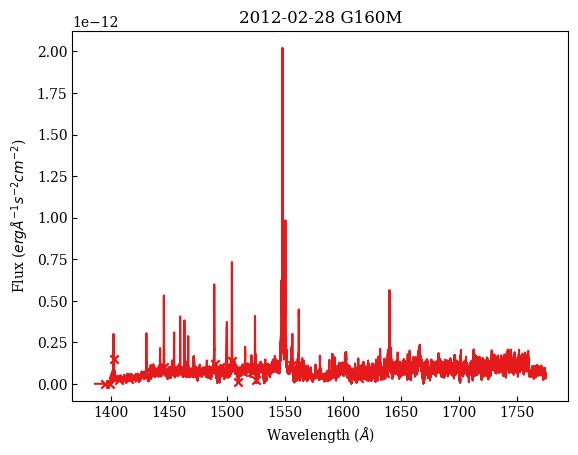

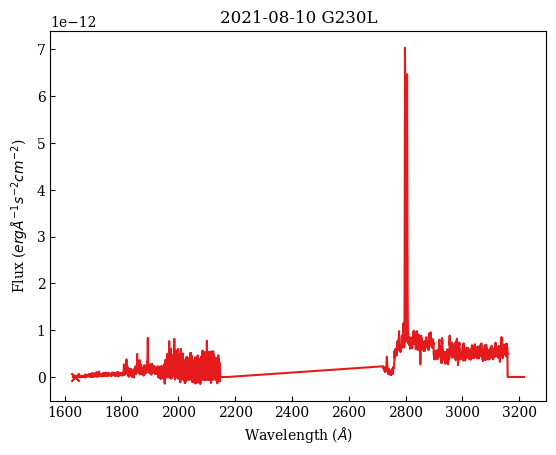

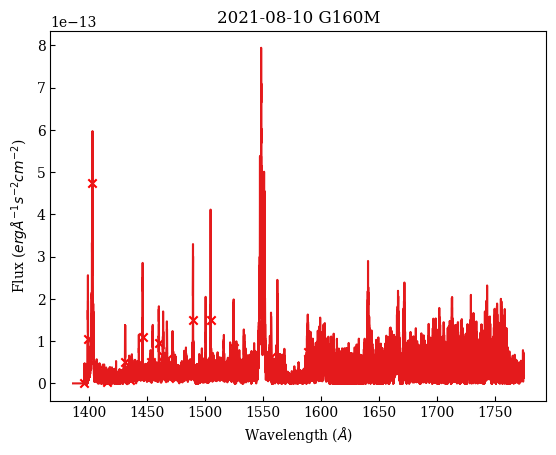

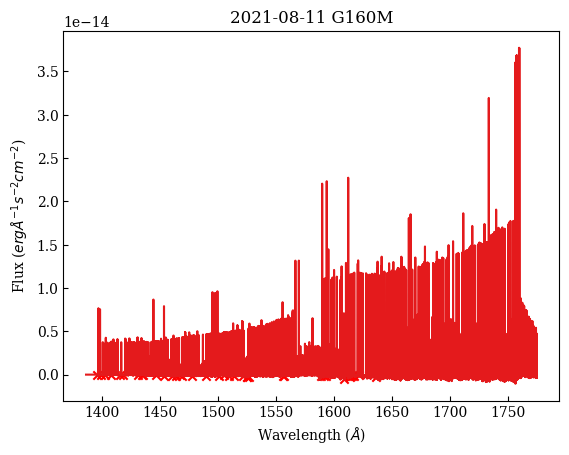

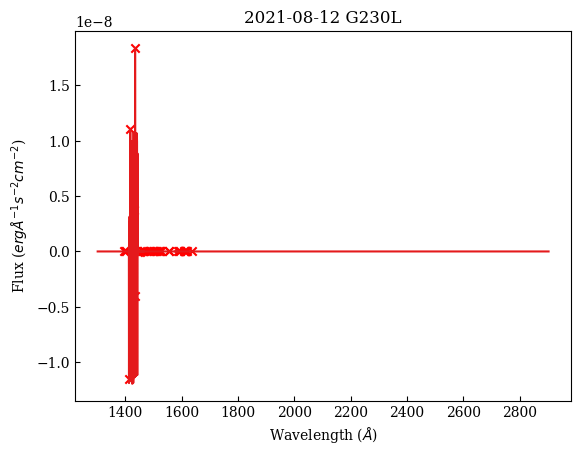

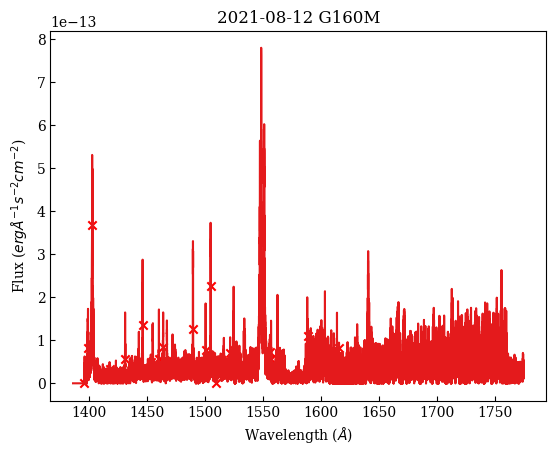

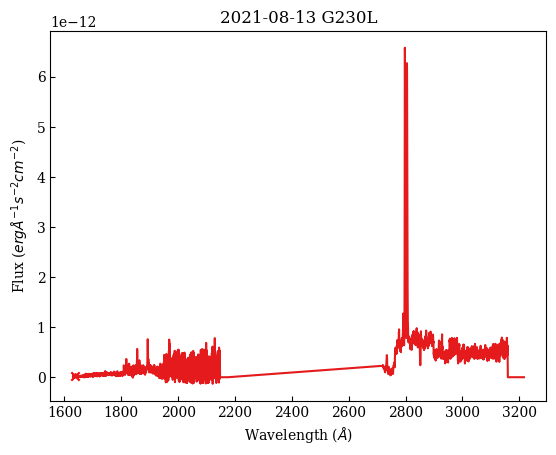

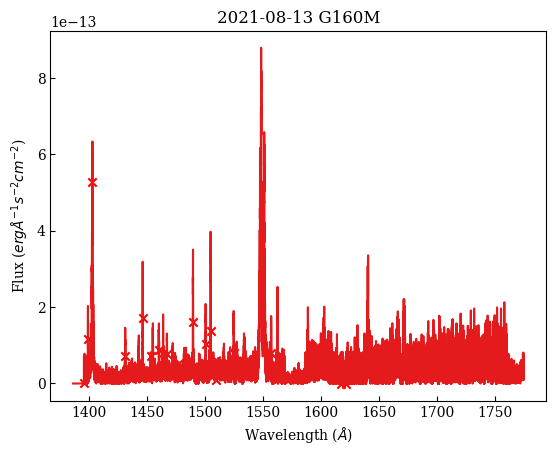

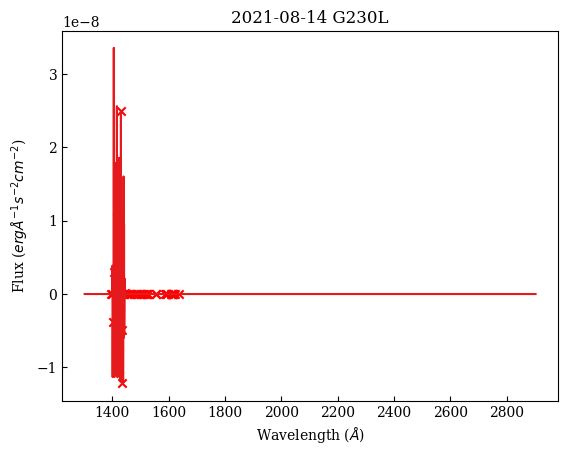

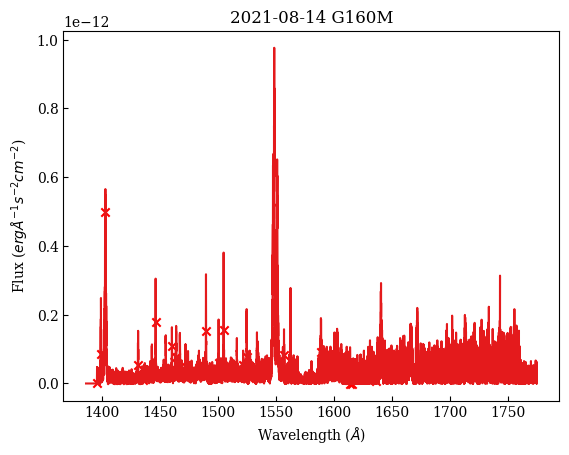

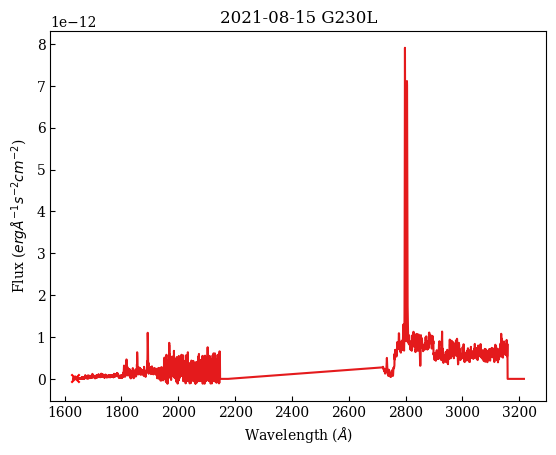

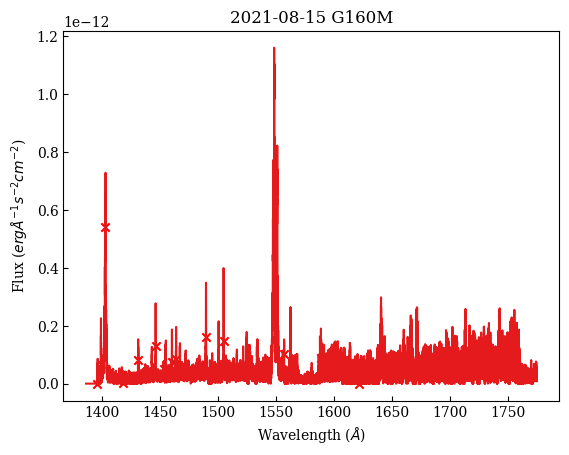

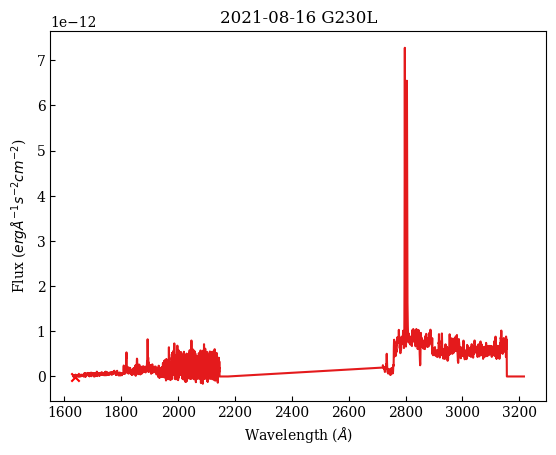

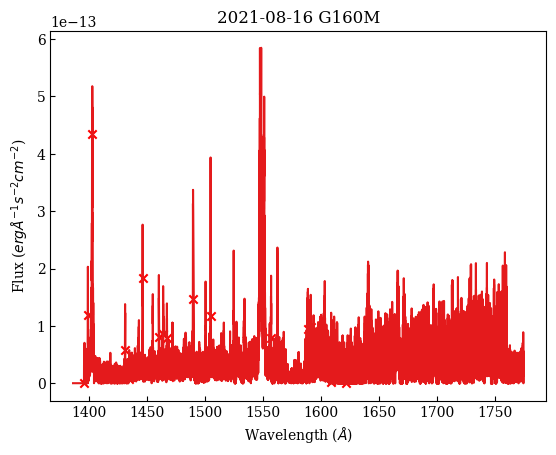

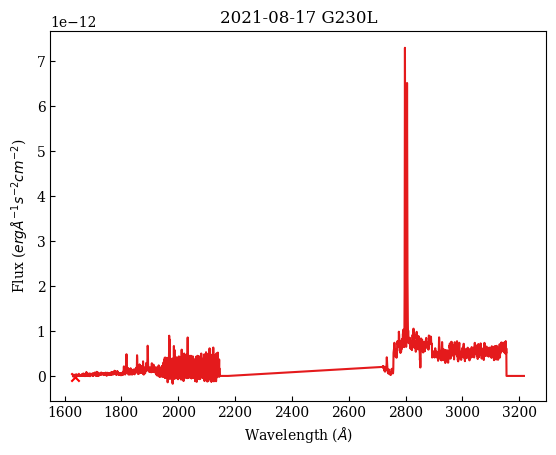

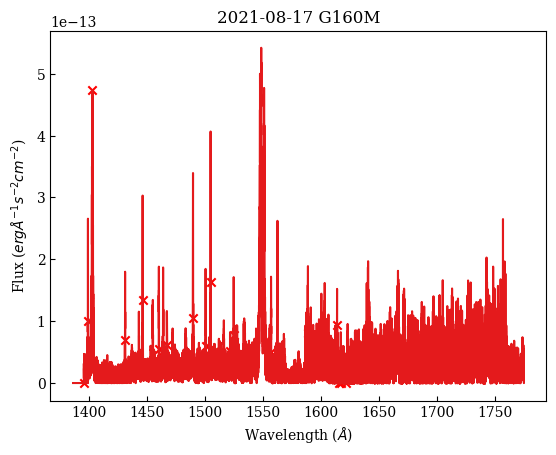

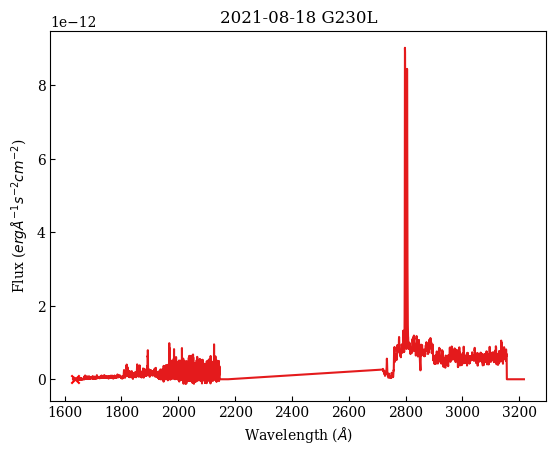

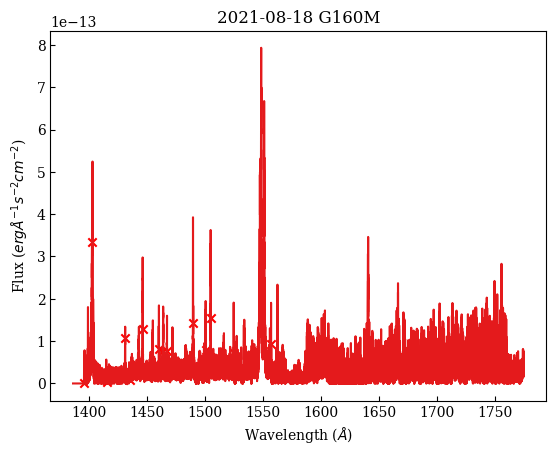

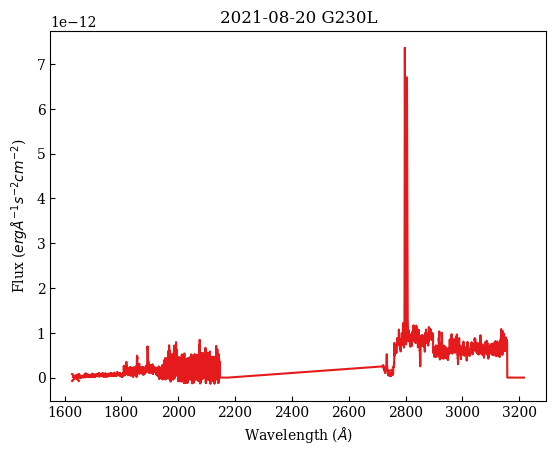

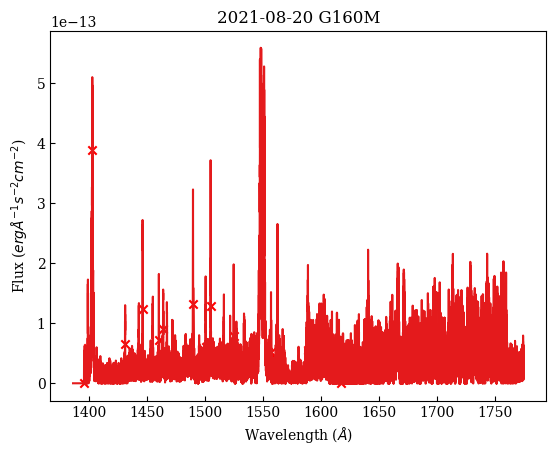

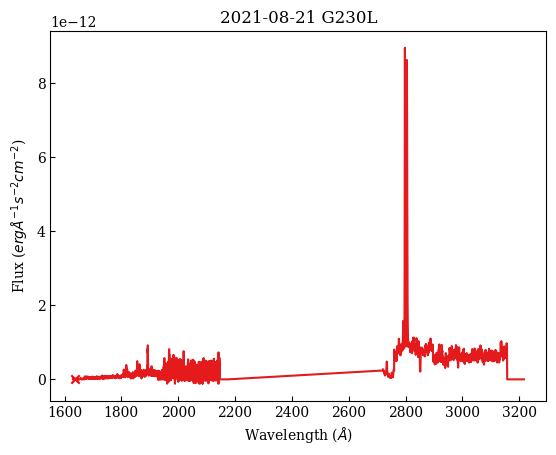

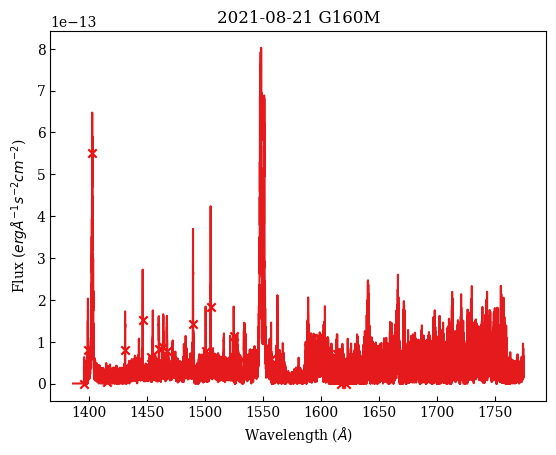

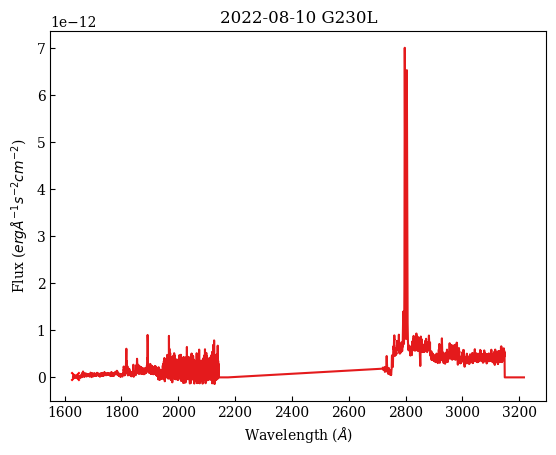

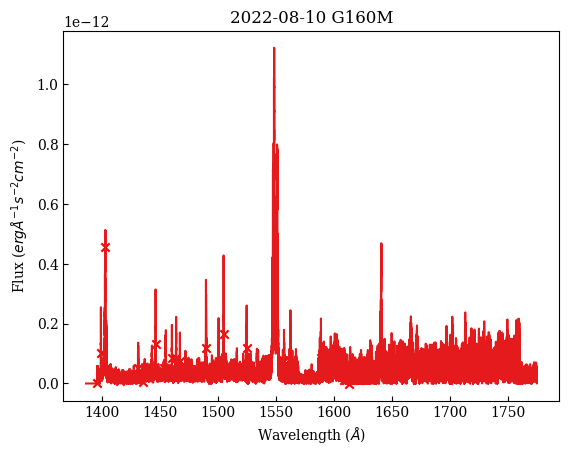

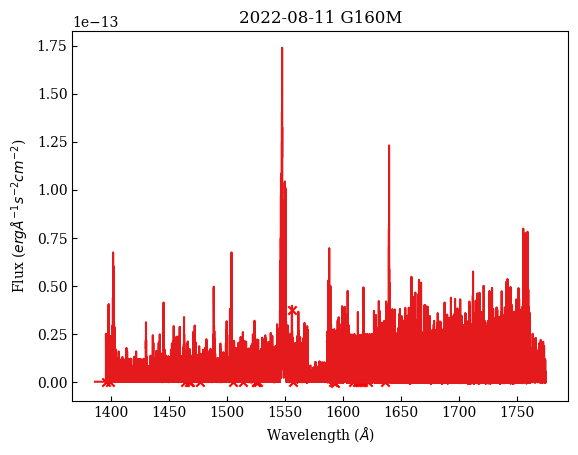

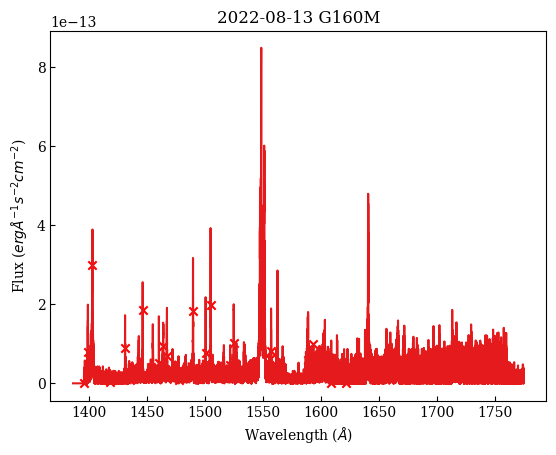

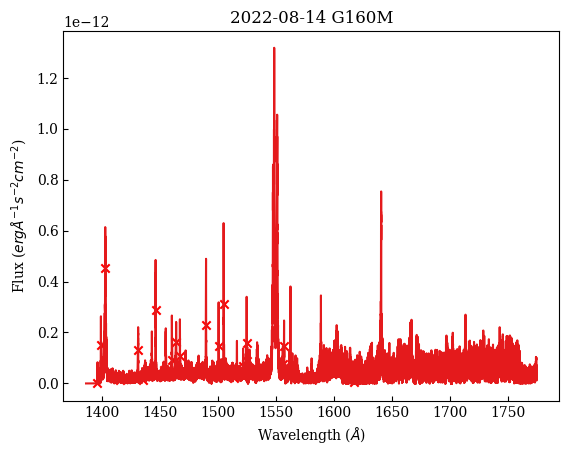

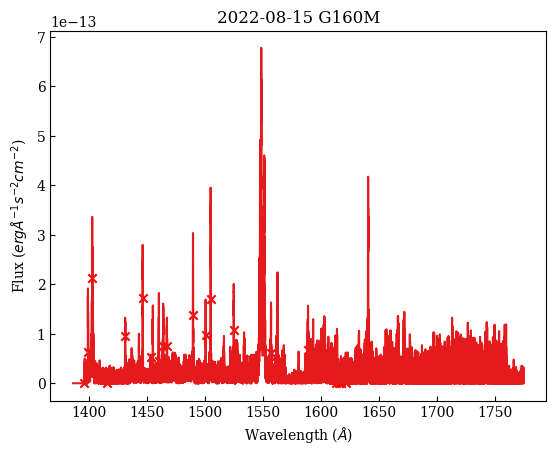

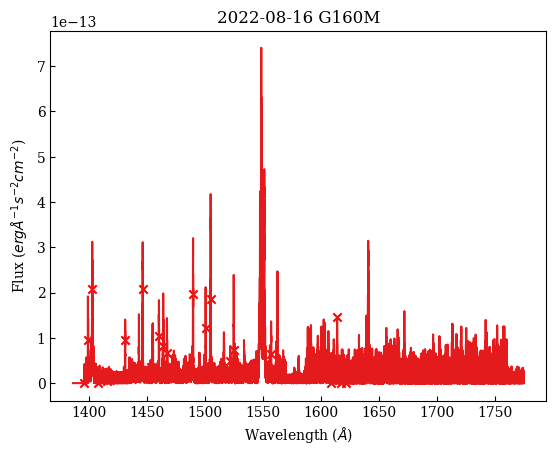

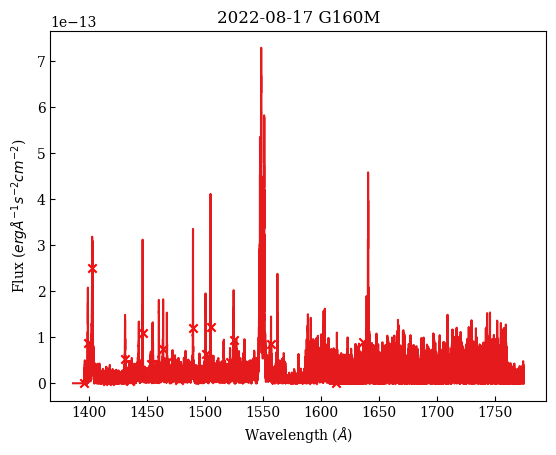

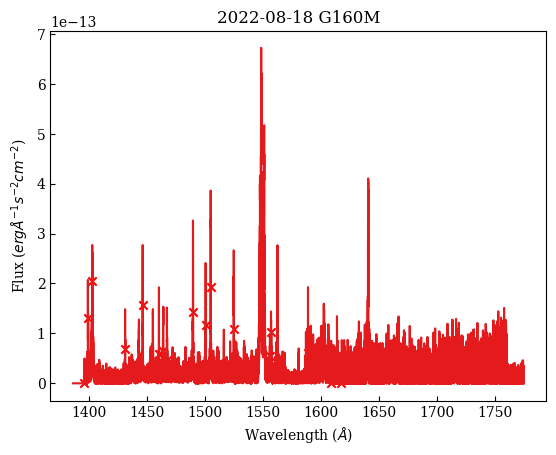

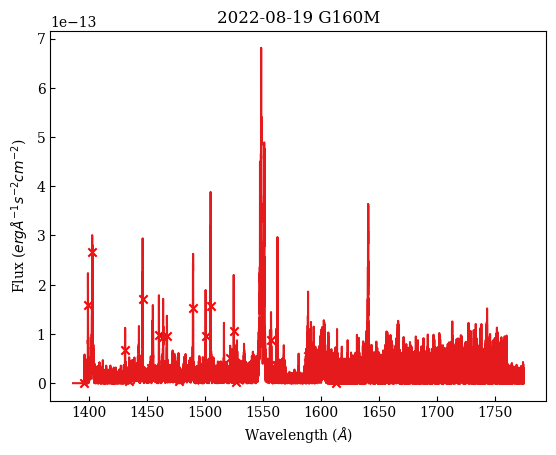

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f60402d15e0>>
Traceback (most recent call last):
  File "/mnt/c/Users/Prerana Kottapalli/Documents/GitHub/scripts_by_me/research24/astrotest/astro-venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


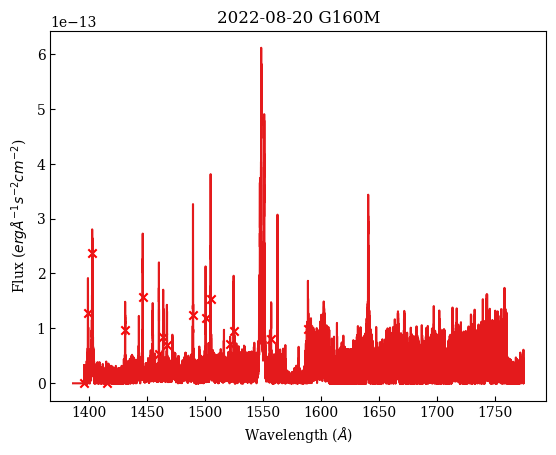

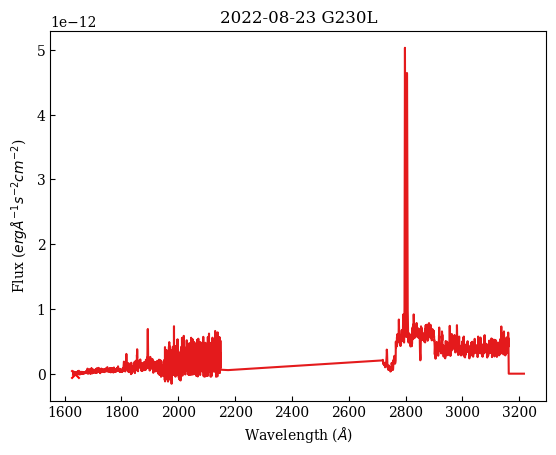

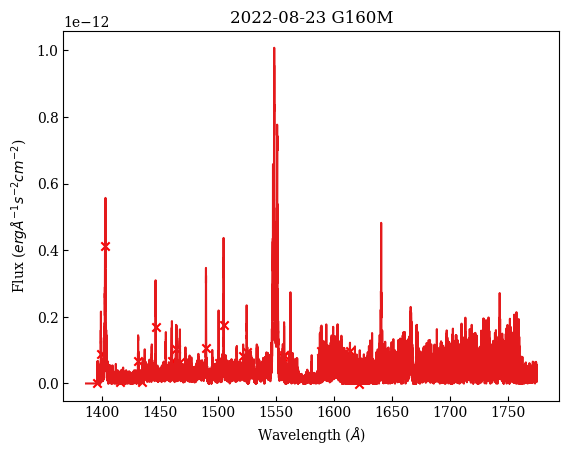

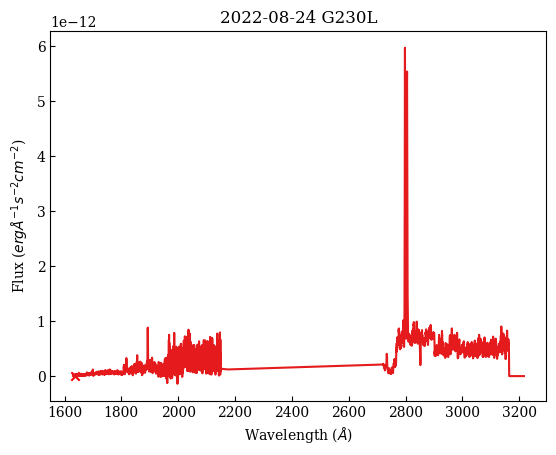

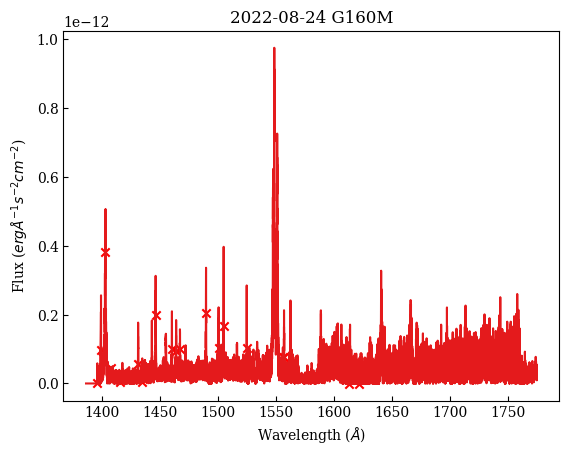

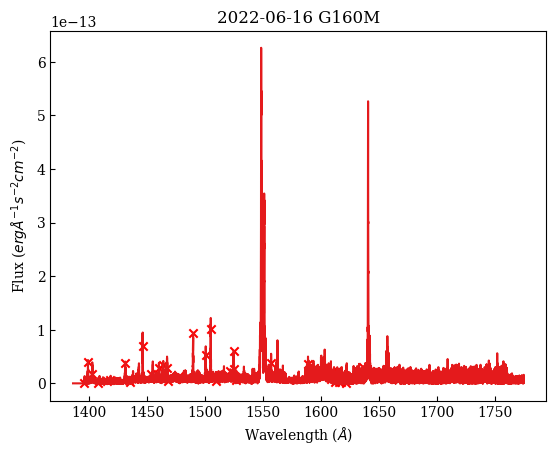

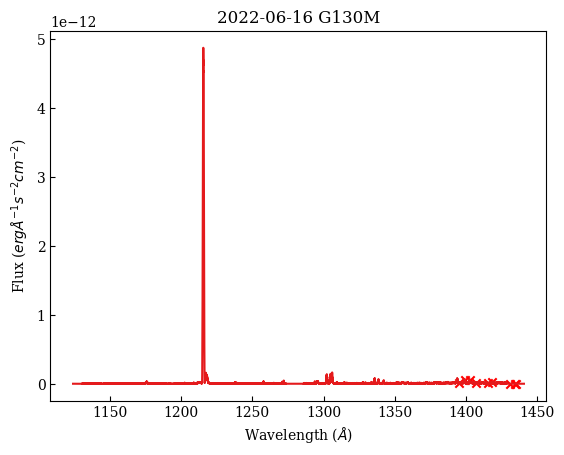

In [32]:
for _, row in stacked_df.iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.scatter(row['wavelength'][row['H2line_idx']], row['flux'][row['H2line_idx']], c='r', marker='x')
    plt.title(row['obsdate']+' '+row['filter'])
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()

# Now investigate individual lines

In [7]:
stacked_df = stacked_df[stacked_df['filter']!='G230L']
stacked_df = stacked_df[stacked_df["[nu', J']"].notna() & (stacked_df["[nu', J']"].apply(len) > 0)] #remove the spectra (coadded for one observation date) that don't have any H2 lines
stacked_df

,obsdate,filter,wavelength,flux,fluxerr,H2line_idx,"[nu', J']",rest_wavelength
0,2011-07-20,G130M,"[1124.7185766387568 Angstrom, 1124.72853832954...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[30169, 30460, 31742, 32148, 28525, 28896, 320...","[[4,13], [3,16], [1,4], [3,0], [0,1], [0,2], [...","[1415.33, 1418.23, 1431.01, 1435.05, 1398.95, ..."
1,2011-07-20,G160M,"[1386.0412954067515 Angstrom, 1386.05353027634...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19172, 19752, 2394, 10087, 19634, 2631, 10458...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
2,2012-02-28,G130M,"[1124.9096635174221 Angstrom, 1124.91962690073...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[30144, 30435, 31718, 32123, 28501, 28872, 320...","[[4,13], [3,16], [1,4], [3,0], [0,1], [0,2], [...","[1415.33, 1418.23, 1431.01, 1435.05, 1398.95, ..."
3,2012-02-28,G160M,"[1386.2769487823698 Angstrom, 1386.28918573199...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19150, 19730, 2374, 10066, 19612, 2611, 10437...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
5,2021-08-10,G160M,"[1385.9946471407397 Angstrom, 1386.00688689571...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10086, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
6,2021-08-11,G160M,"[1385.9941396590698 Angstrom, 1386.00637941009...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10086, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
8,2021-08-12,G160M,"[1385.9934968299058 Angstrom, 1386.00573657483...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10087, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
10,2021-08-13,G160M,"[1385.9931276253203 Angstrom, 1386.00536736705...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10087, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
12,2021-08-14,G160M,"[1385.9926535426373 Angstrom, 1386.00489328013...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10087, 19635, 2634, 10458...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
14,2021-08-15,G160M,"[1385.9921658835162 Angstrom, 1386.00440561677...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19173, 19752, 2397, 10087, 19635, 2634, 10458...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."


In [8]:
line_df = all_spectra.get_lines(stacked_df) #rearrange df by progressions, not obsdate
line_df

,transition,labline,obsdate,wavelength,flux,fluxerr
0,"[2,15]",1612.39,2011-07-20,"[1610.5585003408235 Angstrom, 1610.57073958570...","[5.320080110498594e-14 erg / (Angstrom s cm2),...",[5.3686803216963177e-14 erg / (Angstrom s cm2)...
1,"[2,15]",1617.42,2011-07-20,"[1615.5888299872831 Angstrom, 1615.60106923216...","[7.922408505213248e-14 erg / (Angstrom s cm2),...","[7.349231826721974e-14 erg / (Angstrom s cm2),..."
2,"[2,15]",1612.39,2012-02-28,"[1610.5507632544764 Angstrom, 1610.56300458013...","[8.531146786124105e-14 erg / (Angstrom s cm2),...","[1.250737000261844e-14 erg / (Angstrom s cm2),..."
3,"[2,15]",1617.42,2012-02-28,"[1615.5819480993355 Angstrom, 1615.59418942499...","[7.326233371705557e-14 erg / (Angstrom s cm2),...",[1.1893220798975884e-14 erg / (Angstrom s cm2)...
4,"[2,15]",1612.39,2021-08-10,"[1610.5528748112285 Angstrom, 1610.56512239027...","[2.421800871449174e-14 erg / (Angstrom s cm2),...",[2.2686104499614225e-14 erg / (Angstrom s cm2)...
...,...,...,...,...,...,...
1010,"[3,13]",1615.43,2022-08-23,"[1613.596769899303 Angstrom, 1613.609017434257...",[1.2234205076962212e-13 erg / (Angstrom s cm2)...,"[3.910954022812035e-14 erg / (Angstrom s cm2),..."
1011,"[3,13]",1608.33,2022-08-24,"[1606.4929711547893 Angstrom, 1606.50521868832...",[2.9924169686618985e-14 erg / (Angstrom s cm2)...,"[2.694834295134379e-14 erg / (Angstrom s cm2),..."
1012,"[3,13]",1615.43,2022-08-24,"[1613.5965406064772 Angstrom, 1613.60878814001...","[3.645414658613906e-14 erg / (Angstrom s cm2),...","[2.620746555809019e-14 erg / (Angstrom s cm2),..."
1013,"[3,13]",1608.33,2022-06-16,"[1606.4947618749995 Angstrom, 1606.50701016912...",[2.4744083826911735e-14 erg / (Angstrom s cm2)...,[1.0589358429720741e-14 erg / (Angstrom s cm2)...


# Look for contaminated lines in the [0,1], [0,2], [1,4], [1,7] transitions

{'[0,3]', '[2,12]', '[0,2]', '[1,7]', '[4,13]', '[0,1]', '[3,16]', '[2,15]', '[1,4]', '[3,0]', '[4,4]', '[3,13]'}

In [9]:
exclude_lines = {
    "[0,1]": {
        "dates": ["2022-08-11", "2022-08-24", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2011-07-20", "2012-02-28", "2012-02-28", "2021-08-16", "2022-08-14"],
        "wavelengths": [1460.17, 1521.59, 1521.59, 1398.95, 1460.17, 1521.59, 1398.95, 1521.59, 1398.95, 1521.59, 1521.59]
    },
    "[0,2]": {
        "dates": ["2022-06-16", "2022-08-11", "2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2022-08-10", "2022-08-13"],
        "wavelengths": [1525.15, 1463.83, 1525.15, 1402.65, 1463.83, 1525.15, 1402.65, 1525.15, 1525.15]
    },
    "[1,4]": {
        "dates": ["2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11"],
        "wavelengths": [1431.01, 1431.01, 1446.12, 1489.57, 1504.76]
    },
    "[1,7]": {
        "dates": ["All", "All", "2022-08-11", "2022-08-11", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2021-08-21", "2022-08-18"],
        "wavelengths": [1556.87, 1524.65, 1467.08, 1500.45, 1556.87, 1467.08, 1500.45, 1524.65, 1556.87, 1556.87, 1556.87, 1556.87]
    },
    "[2,12]": {
        'dates': ['2021-08-10', '2021-08-18', '2021-08-18', '2022-06-16', '2022-06-16', '2022-08-1', '2022-08-11', '2022-08-11', '2021-08-20', '2011-07-20', '2021-08-11', '2021-08-11', '2021-08-11', '2012-02-28', '2021-08-16', '2021-08-12', '2022-08-10', "All"],
        "wavelengths": [1453.10, 1555.89, 1588.8, 1453.1, 1555.89, 1453.1, 1555.89, 1588.8, 1555.89, 1588.8, 1453.1, 1555.89, 1588.8, 1555.89, 1453.1, 1555.89, 1453.1, 1434.54]
    }
}

In [10]:
# exclude bad/contaminated lines from coadding
bad_transitions = ['[3,0]', '[4,13]', '[3,13]', '[4,4]', '[2,15]', '[3,16]', '[4,0]']
bad_transitions_mask = ~line_df['transition'].isin(bad_transitions)
line_df_good = line_df[bad_transitions_mask]

contaminated = []
for transition in exclude_lines.keys():
    dates = exclude_lines[transition]['dates']
    lines_ex = exclude_lines[transition]['wavelengths']
    for d, w in zip(dates, lines_ex):
        if d == "All":
            exclude_idx = line_df_good.index[(line_df_good['transition']==transition)&(line_df_good['labline']==w)].tolist()
        else:
            exclude_idx = line_df_good.index[(line_df_good['transition']==transition)&(line_df_good['labline']==w)&(line_df_good['obsdate']==d)].tolist()
        contaminated.extend(exclude_idx)

line_df_good = line_df_good.drop(index=contaminated)

line_df_good = line_df_good[line_df_good['obsdate']!='2021-08-11']
line_df_good

,transition,labline,obsdate,wavelength,flux,fluxerr
54,"[2,12]",1453.10,2011-07-20,"[1451.2653852164988 Angstrom, 1451.27762008609...","[2.83376381542378e-14 erg / (Angstrom s cm2), ...",[2.7870146090535857e-14 erg / (Angstrom s cm2)...
55,"[2,12]",1555.89,2011-07-20,"[1554.0505246822067 Angstrom, 1554.06275955180...","[3.556962846613925e-14 erg / (Angstrom s cm2),...",[4.1275793354704435e-14 erg / (Angstrom s cm2)...
59,"[2,12]",1453.10,2012-02-28,"[1451.267388244087 Angstrom, 1451.279625193712...","[4.588279175468525e-14 erg / (Angstrom s cm2),...","[6.031634528287674e-15 erg / (Angstrom s cm2),..."
61,"[2,12]",1588.80,2012-02-28,"[1586.961728714225 Angstrom, 1586.973970039881...","[3.723534267351274e-14 erg / (Angstrom s cm2),...","[7.688827982724632e-15 erg / (Angstrom s cm2),..."
64,"[2,12]",1555.89,2021-08-10,"[1554.0587226653352 Angstrom, 1554.07096242030...",[2.6080615027603345e-14 erg / (Angstrom s cm2)...,[1.7868420511984373e-14 erg / (Angstrom s cm2)...
...,...,...,...,...,...,...
880,"[1,4]",1431.01,2022-06-16,"[1429.1742488834152 Angstrom, 1429.18648935300...","[6.477368520837936e-15 erg / (Angstrom s cm2),...",[2.7239191182591434e-15 erg / (Angstrom s cm2)...
881,"[1,4]",1446.12,2022-06-16,"[1444.2789883630503 Angstrom, 1444.29122883264...","[5.236299078879322e-15 erg / (Angstrom s cm2),...","[3.399547261070788e-15 erg / (Angstrom s cm2),..."
882,"[1,4]",1489.57,2022-06-16,"[1487.7326554235885 Angstrom, 1487.74489589318...","[8.123274407050263e-15 erg / (Angstrom s cm2),...","[3.618991770647724e-15 erg / (Angstrom s cm2),..."
883,"[1,4]",1504.76,2022-06-16,"[1502.9230781903852 Angstrom, 1502.93531865997...",[1.0323481281607505e-14 erg / (Angstrom s cm2)...,"[5.786103921182803e-15 erg / (Angstrom s cm2),..."


# Coadd progressions

In [12]:
df = line_df_good[(line_df_good['transition']=='[1,4]') & (line_df_good['obsdate']=='2011-07-20')]
columns=['obsdate', 'transition']
velocity=True
res = {}
combinations = df[columns].drop_duplicates()
for _, row in combinations.iterrows():
    unique_values = [row[col] for col in columns]

    # Filter the group
    mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
    group = df[mask]

    resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
    wavelengths = group['wavelength'].values
    fluxes = group['flux'].values
    fluxerrs = group['fluxerr'].values
    if velocity:
        lablines = group['labline'].values*all_spectra.wavelength_units
    else:
        lablines = [None] * len(wavelengths)
    
    template_axis = wavelengths[0][np.argsort(wavelengths[0])]
    template_flux = fluxes[0][np.argsort(wavelengths[0])]
    template_fluxerr = fluxerrs[0][np.argsort(wavelengths[0])]
    
    template = Spectrum1D(
        flux=template_flux,
        spectral_axis=template_axis,
        uncertainty=StdDevUncertainty(template_fluxerr)
    )
    for i in np.arange(1, len(wavelengths)):
        x = wavelengths[i]
        flux = fluxes[i]
        err = fluxerrs[i]
        sort_idx = np.argsort(x)
        spec = Spectrum1D(spectral_axis=x[sort_idx], 
                            flux=flux[sort_idx], 
                            uncertainty=StdDevUncertainty(err[sort_idx])
                        )
        if velocity:
            spec.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=lablines[i])
            template.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=lablines[0])
            new_spectral_axis = template.spectral_axis
        
        spec_resampled = resampler(spec, new_spectral_axis)
        template += spec_resampled
    
    coadd_wave = template.wavelength
    coadd_flux = template.flux
    coadd_err = template.uncertainty.quantity.to(all_spectra.flux_units)
    if velocity:
        coadd_vel = template.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=lablines[0])
        spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err, 'velocity': coadd_vel}
    else:
        spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err}
    res[tuple(unique_values)] = spec_dict

prog_df = pd.DataFrame([
    {**dict(zip(columns, k)), **(v if v is not None else {})}
    for k, v in res.items()
])

In [1]:
#Try checking what the wavelengths looks like once resampled, just try for two spectra.

In [57]:
#coadd all spectral lines in the same progression for better SNR
prog_df = all_spectra.coaddwave(line_df_good, columns=['obsdate', 'transition'], velocity=True)
prog_df

,obsdate,transition,wavelength,flux,fluxerr,velocity
0,2011-07-20,"[1,7]","[1465.2498411633273 Angstrom, 1465.26207603292...",[1.4274523416556606e-13 erg / (Angstrom s cm2)...,"[4.593499332648668e-14 erg / (Angstrom s cm2),...","[-373.986296709459 km / s, -371.4861456412979 ..."
1,2012-02-28,"[1,7]","[1465.2419847165559 Angstrom, 1465.25422166618...",[1.2537624359269909e-13 erg / (Angstrom s cm2)...,[1.0660611170290324e-14 erg / (Angstrom s cm2)...,"[-375.59173301065687 km / s, -373.091156895753..."
2,2021-08-10,"[1,7]","[1465.247060586356 Angstrom, 1465.259300341328...",[2.1525400145306868e-14 erg / (Angstrom s cm2)...,[1.3262403079630059e-14 erg / (Angstrom s cm2)...,"[-374.5544974925798 km / s, -372.0533481152513..."
3,2021-08-12,"[1,7]","[1465.2458452615183 Angstrom, 1465.25808500644...","[4.874913431857607e-14 erg / (Angstrom s cm2),...",[1.6198784390503573e-14 erg / (Angstrom s cm2)...,"[-374.80284469952437 km / s, -372.301697373999..."
4,2021-08-13,"[1,7]","[1465.2454553716614 Angstrom, 1465.25769511339...","[4.46362569452179e-14 erg / (Angstrom s cm2), ...",[1.5886365071320577e-14 erg / (Angstrom s cm2)...,"[-374.8825172726349 km / s, -372.3813705999025..."
...,...,...,...,...,...,...
144,2022-08-19,"[2,12]","[1451.265100728928 Angstrom, 1451.277340448911...",[6.3725539202575906e-15 erg / (Angstrom s cm2)...,[1.1836366410559679e-14 erg / (Angstrom s cm2)...,"[-378.56235817016557 km / s, -376.037152926888..."
145,2022-08-20,"[2,12]","[1451.2647620994849 Angstrom, 1451.27700181674...",[3.2120701914552006e-14 erg / (Angstrom s cm2)...,[1.5004230418026618e-14 erg / (Angstrom s cm2)...,"[-378.6322216022025 km / s, -376.1070169204874..."
146,2022-08-23,"[2,12]","[1451.2640370666647 Angstrom, 1451.27627677757...","[4.750287401578107e-14 erg / (Angstrom s cm2),...",[1.6468579579596158e-14 erg / (Angstrom s cm2)...,"[-378.7818048182756 km / s, -376.2566014464385..."
147,2022-08-24,"[2,12]","[1451.2638487281617 Angstrom, 1451.27608843765...","[4.220315240638004e-14 erg / (Angstrom s cm2),...",[1.6476620071988315e-14 erg / (Angstrom s cm2)...,"[-378.8206613751288 km / s, -376.2954582954223..."


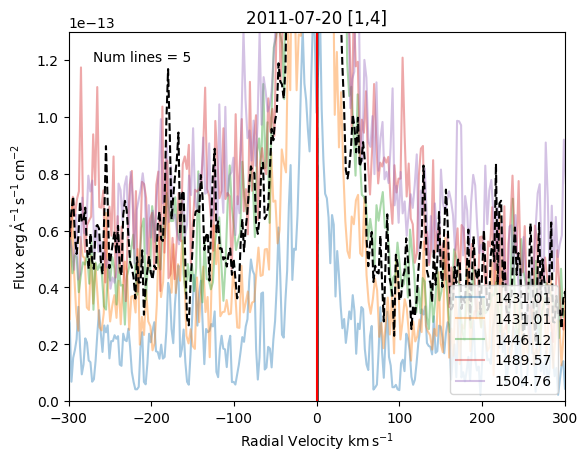

In [14]:
#for transition_plot in prog_df['transition'].unique():
ibm_colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
for transition_plot in ['[1,4]']:
    mask = prog_df['transition']==transition_plot

    for _, row in prog_df[mask].iterrows():
        plt.title(row['obsdate']+' '+transition_plot)
        coadd_lines = line_df_good[(line_df_good['transition']==transition_plot) & (line_df_good['obsdate']==row['obsdate'])]
        for i, row_line in coadd_lines.iterrows():
            velocity = all_spectra.radial_velocity(row_line['wavelength'], row_line['labline'])
            plt.fill_between(row_line['flux'].value+row_line['fluxerr'].value, row_line['flux'].value-row_line['fluxerr'].value, alpha=0.2, color='black')
            plt.plot(velocity, row_line['flux'], alpha=0.4, label=row_line['labline'])

        plt.plot(row['velocity'], row['flux'], c='black', ls='--')
        plt.vlines(0, 0,1.3e-13, 'r')
        plt.xlabel('Radial Velocity'+' '+u.format.Latex().to_string(row['velocity'].unit, fraction=False))
        plt.ylabel('Flux'+' '+u.format.Latex().to_string(row['flux'].unit, fraction=False))
        plt.text(0.05, 0.95, f'Num lines = {len(coadd_lines)}', transform=plt.gca().transAxes, verticalalignment='top')
        plt.ylim(0, 1.3e-13)
        plt.xlim(-300,300)
        plt.legend(loc='lower right')
        plt.show()